In [1]:
import gdown
gdown.download('https://drive.google.com/uc?id=1JqrbULKkHKFD7JJMfbApNx3zbn99xN04', 'DIARETDB1.zip', quiet=False)
!unzip DIARETDB1.zip -d DIARETDB1_DATA/

Downloading...
From (original): https://drive.google.com/uc?id=1JqrbULKkHKFD7JJMfbApNx3zbn99xN04
From (redirected): https://drive.google.com/uc?id=1JqrbULKkHKFD7JJMfbApNx3zbn99xN04&confirm=t&uuid=77597da7-fff1-4184-a15b-a70387d45ed7
To: /content/DIARETDB1.zip
100%|██████████| 145M/145M [00:02<00:00, 49.3MB/s]


Archive:  DIARETDB1.zip
   creating: DIARETDB1_DATA/DIARETDB1/
  inflating: DIARETDB1_DATA/DIARETDB1/ddb1_v02_01_test.txt  
  inflating: DIARETDB1_DATA/DIARETDB1/ddb1_v02_01_test_plain.txt  
  inflating: DIARETDB1_DATA/DIARETDB1/ddb1_v02_01_train.txt  
  inflating: DIARETDB1_DATA/DIARETDB1/ddb1_v02_01_train_plain.txt  
   creating: DIARETDB1_DATA/DIARETDB1/groundtruth/
  inflating: DIARETDB1_DATA/DIARETDB1/groundtruth/diaretdb1_image001_01.xml  
  inflating: DIARETDB1_DATA/DIARETDB1/groundtruth/diaretdb1_image001_01_plain.xml  
  inflating: DIARETDB1_DATA/DIARETDB1/groundtruth/diaretdb1_image001_02.xml  
  inflating: DIARETDB1_DATA/DIARETDB1/groundtruth/diaretdb1_image001_02_plain.xml  
  inflating: DIARETDB1_DATA/DIARETDB1/groundtruth/diaretdb1_image001_03.xml  
  inflating: DIARETDB1_DATA/DIARETDB1/groundtruth/diaretdb1_image001_03_plain.xml  
  inflating: DIARETDB1_DATA/DIARETDB1/groundtruth/diaretdb1_image001_04.xml  
  inflating: DIARETDB1_DATA/DIARETDB1/groundtruth/diaretdb1_imag

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Starting training...
Epoch 1/20 - Train Loss: 0.6096 - Val Loss: 0.7028 - LR: 1.00e-04
  ✓ New best model saved with validation loss: 0.7028
Epoch 2/20 - Train Loss: 0.5164 - Val Loss: 0.7480 - LR: 1.00e-04
Epoch 3/20 - Train Loss: 0.5642 - Val Loss: 0.8411 - LR: 1.00e-04
Epoch 4/20 - Train Loss: 0.5388 - Val Loss: 0.9305 - LR: 1.00e-04
Epoch 5/20 - Train Loss: 0.3657 - Val Loss: 0.9052 - LR: 1.00e-04
Epoch 6/20 - Train Loss: 0.4861 - Val Loss: 0.8639 - LR: 5.00e-05
Epoch 7/20 - Train Loss: 0.5111 - Val Loss: 0.8369 - LR: 5.00e-05
Epoch 8/20 - Train Loss: 0.3823 - Val Loss: 0.8398 - LR: 5.00e-05
Epoch 9/20 - Train Loss: 0.4195 - Val Loss: 0.8397 - LR: 5.00e-05
Epoch 10/20 - Train Loss: 0.3941 - Val Loss: 0.8250 - LR: 2.50e-05
Epoch 11/20 - Train Loss: 0.3645 - Val Loss: 0.8037 - LR: 2.50e-05
Epoch 12/20 - Train Loss: 0.4136 - Val Loss: 0.7968 - LR: 2.50e-05
Epoch 13/20 - Train Loss: 0.3834 - Val Loss: 0.8189 - LR: 2.50e-05
Epoch 14/20 - Train Loss: 0.4096 - Val Loss: 0.8328 - LR: 1.25e

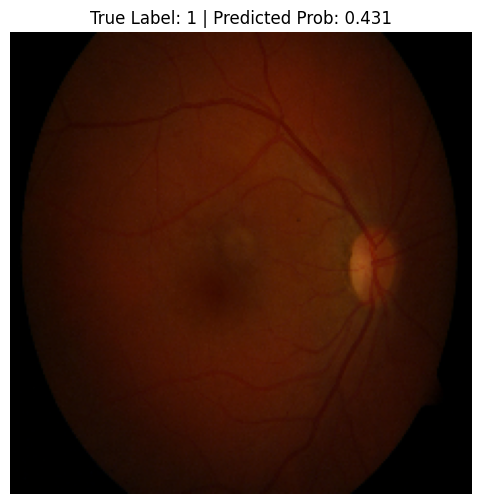

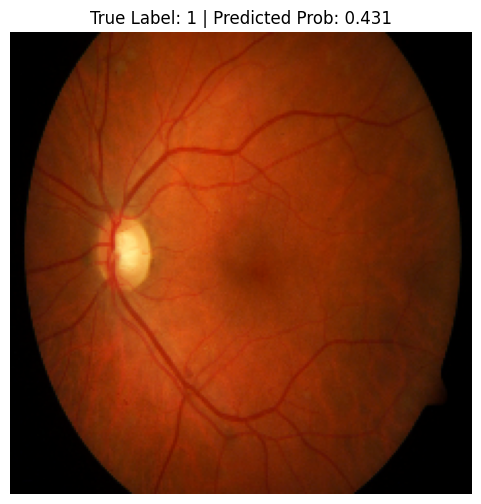

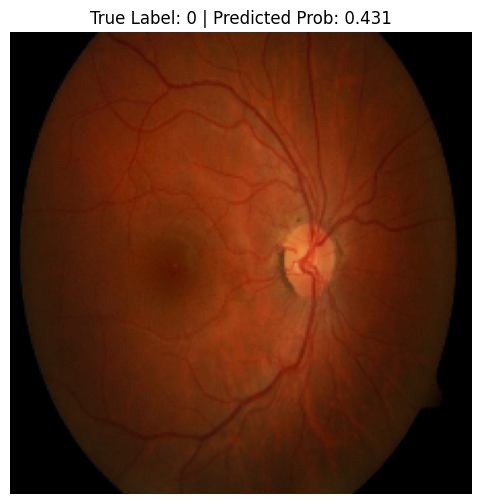

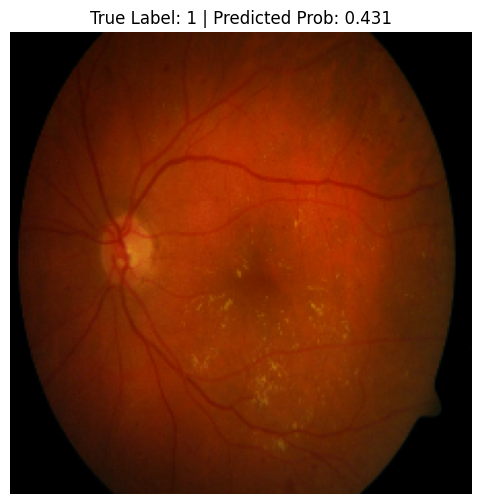

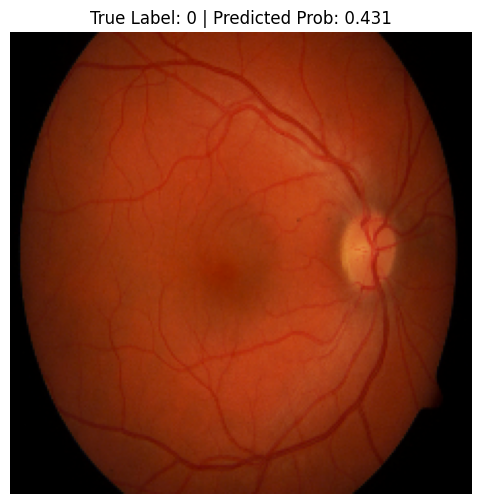


Test Results:
Test Accuracy: 0.3889
Test Loss: 0.7202
Test set - Positive samples: 11, Negative samples: 7


In [2]:
import os
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -------- Model Definition --------

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class ResUNetEncoder(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        for feature in features:
            self.encoder_blocks.append(ConvBlock(in_channels, feature))
            in_channels = feature

    def forward(self, x):
        for encoder in self.encoder_blocks:
            x = encoder(x)
            x = self.pool(x)
        return x

class ResUNetClassifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder = ResUNetEncoder(in_channels, features)
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # output 1x1 feature map
        self.classifier = nn.Linear(features[-1], num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  # raw logits for BCEWithLogitsLoss

# -------- Dataset --------

class RetinalHemorrhageDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, file_names, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.file_names = file_names
        self.transform = transform

    def check_hemorrhages_in_xml(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            for marking in root.findall('.//marking'):
                marking_type = marking.find('markingtype').text.strip()
                if 'Haemorrhages' in marking_type:
                    return 1
            return 0
        except Exception as e:
            print(f"Error parsing XML: {annotation_path}, {e}")
            return 0

    def parse_annotations(self, image_name):
        base_name = image_name.replace('.png', '')
        xml_files = [f for f in os.listdir(self.annotation_dir) if f.startswith(base_name) and f.endswith('.xml')]
        for xml_file in xml_files:
            if not xml_file.endswith('_plain.xml'):
                label = self.check_hemorrhages_in_xml(os.path.join(self.annotation_dir, xml_file))
                if label == 1:
                    return 1
        return 0

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = self.file_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = np.array(Image.open(img_path).convert("RGB"))

        label = self.parse_annotations(img_name)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            image = ToTensorV2()(image=image)['image']

        return image, torch.tensor(label, dtype=torch.float32)

# -------- Transforms --------

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# -------- Prepare Data --------

image_dir = '/content/DIARETDB1_DATA/DIARETDB1/images'
annotation_dir = '/content/DIARETDB1_DATA/DIARETDB1/groundtruth'  # your XML files location

all_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

train_dataset = RetinalHemorrhageDataset(image_dir, annotation_dir, train_files, transform=train_transform)
val_dataset = RetinalHemorrhageDataset(image_dir, annotation_dir, val_files, transform=val_transform)
test_dataset = RetinalHemorrhageDataset(image_dir, annotation_dir, test_files, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# -------- Loss & Optimizer --------

criterion = nn.BCEWithLogitsLoss()

# -------- Training & Validation Loops --------

def train_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)  # shape: (B,1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

def eval_epoch(model, loader, device):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

    return running_loss / len(loader)

# -------- Main Training --------

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResUNetClassifier()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Removed verbose=True to avoid deprecation warning
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

epochs = 20
best_val_loss = float('inf')
best_model_path = "best_resunet_classifier.pth"

print("Starting training...")
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = eval_epoch(model, val_loader, device)

    # Get current learning rate for display
    current_lr = optimizer.param_groups[0]['lr']

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - LR: {current_lr:.2e}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✓ New best model saved with validation loss: {val_loss:.4f}")

print(f"\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best model saved as: {best_model_path}")

# -------- Load Best Model for Testing --------

# Load the best model for testing
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from {best_model_path}")

# -------- Testing and Visualization --------

def visualize_classification(image, label, pred_logit):
    # Denormalize image for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = image.permute(1, 2, 0).cpu().numpy()
    image = image * std + mean
    image = np.clip(image, 0, 1)

    pred_prob = torch.sigmoid(pred_logit).item()
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"True Label: {int(label.item())} | Predicted Prob: {pred_prob:.3f}")
    plt.axis('off')
    plt.show()

# Test the model
print("\nTesting the best model...")
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(images)
        for i in range(min(5, images.size(0))):
            visualize_classification(images[i], labels[i], outputs[i])
        break

# -------- Additional Evaluation Metrics --------

def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Convert to probabilities and predictions
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = (all_preds == all_labels).mean()
    avg_loss = total_loss / len(loader)

    return accuracy, avg_loss, all_preds, all_labels

# Evaluate on test set
test_accuracy, test_loss, test_preds, test_labels = evaluate_model(model, test_loader, device)
print(f"\nTest Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Print class distribution
pos_samples = np.sum(test_labels)
neg_samples = len(test_labels) - pos_samples
print(f"Test set - Positive samples: {int(pos_samples)}, Negative samples: {int(neg_samples)}")

Analyzing dataset...
Total dataset: 89 images
Positive samples: 54 (60.7%)
Negative samples: 35 (39.3%)

Stratified split:
Train: 62 (Pos: 38, Neg: 24)
Val: 13 (Pos: 8, Neg: 5)
Test: 14 (Pos: 8, Neg: 6)
Using weighted loss with pos_weight: 0.65
Starting enhanced training with early stopping...


<ipython-input-3-35cc17cea12e>:45: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


Epoch 1/50
  Train - Loss: 0.5408, Acc: 0.6452
  Val   - Loss: 0.5411, Acc: 0.3846
  LR: 1.00e-04
  ✓ New best model saved! Val Loss: 0.5411, Val Acc: 0.3846
--------------------------------------------------
Epoch 2/50
  Train - Loss: 0.5407, Acc: 0.6452
  Val   - Loss: 0.5452, Acc: 0.3846
  LR: 1.00e-04
--------------------------------------------------
Epoch 3/50
  Train - Loss: 0.5129, Acc: 0.5323
  Val   - Loss: 0.5241, Acc: 0.4615
  LR: 1.00e-04
  ✓ New best model saved! Val Loss: 0.5241, Val Acc: 0.4615
--------------------------------------------------
Epoch 4/50
  Train - Loss: 0.4773, Acc: 0.6290
  Val   - Loss: 0.5125, Acc: 0.5385
  LR: 1.00e-04
  ✓ New best model saved! Val Loss: 0.5125, Val Acc: 0.5385
--------------------------------------------------
Epoch 5/50
  Train - Loss: 0.5443, Acc: 0.6452
  Val   - Loss: 0.4678, Acc: 0.7692
  LR: 1.00e-04
  ✓ New best model saved! Val Loss: 0.4678, Val Acc: 0.7692
--------------------------------------------------
Epoch 6/50
  Tr

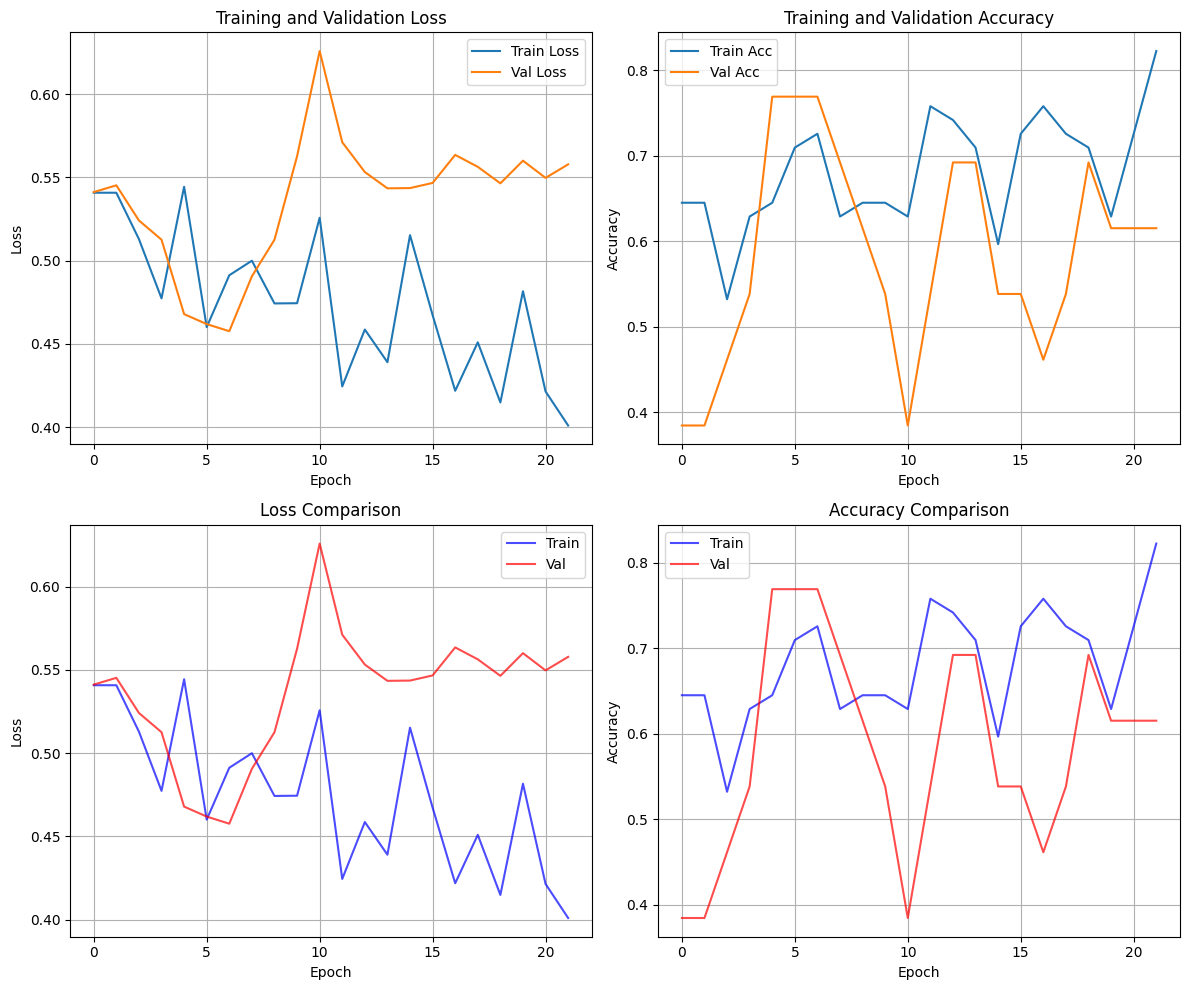


Training completed!
Best model saved as: best_resunet_classifier.pth


In [3]:
# -------- Improved Data Split and Analysis --------

# First, let's analyze the full dataset
print("Analyzing dataset...")
all_labels = []
for file_name in all_files:
    temp_dataset = RetinalHemorrhageDataset(image_dir, annotation_dir, [file_name])
    _, label = temp_dataset[0]
    all_labels.append(label.item())

all_labels = np.array(all_labels)
pos_count = np.sum(all_labels)
neg_count = len(all_labels) - pos_count

print(f"Total dataset: {len(all_files)} images")
print(f"Positive samples: {int(pos_count)} ({pos_count/len(all_labels)*100:.1f}%)")
print(f"Negative samples: {int(neg_count)} ({neg_count/len(all_labels)*100:.1f}%)")

# Better stratified split to ensure balanced representation
from sklearn.model_selection import train_test_split

# Use stratified split to maintain class balance
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"\nStratified split:")
print(f"Train: {len(train_files)} (Pos: {int(np.sum(train_labels))}, Neg: {int(len(train_labels) - np.sum(train_labels))})")
print(f"Val: {len(val_files)} (Pos: {int(np.sum(val_labels))}, Neg: {int(len(val_labels) - np.sum(val_labels))})")
print(f"Test: {len(test_files)} (Pos: {int(np.sum(test_labels))}, Neg: {int(len(test_labels) - np.sum(test_labels))})")

# -------- Enhanced Data Augmentation --------

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# -------- Weighted Loss for Class Imbalance --------

# Calculate class weights
pos_weight = torch.tensor(neg_count / pos_count) if pos_count > 0 else torch.tensor(1.0)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(f"Using weighted loss with pos_weight: {pos_weight.item():.2f}")

# -------- Enhanced Model with Dropout --------

class ImprovedResUNetClassifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, features=[64, 128, 256, 512], dropout=0.5):
        super().__init__()
        self.encoder = ResUNetEncoder(in_channels, features)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(features[-1], 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# -------- Enhanced Training with Early Stopping --------

def train_with_monitoring(model, train_loader, val_loader, criterion, optimizer, scheduler,
                         device, epochs=50, patience=10):

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_loss = float('inf')
    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_model_path = "best_resunet_classifier.pth"

    print("Starting enhanced training with early stopping...")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # Calculate averages
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"  Val   - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.2e}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"  ✓ New best model saved! Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping after {epoch+1} epochs (no improvement for {patience} epochs)")
            break

        print("-" * 50)

    return train_losses, val_losses, train_accs, val_accs, best_model_path

# -------- Main Training --------

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ImprovedResUNetClassifier(dropout=0.3)
model.to(device)

# Recreate datasets with new splits
train_dataset = RetinalHemorrhageDataset(image_dir, annotation_dir, train_files, transform=train_transform)
val_dataset = RetinalHemorrhageDataset(image_dir, annotation_dir, val_files, transform=val_transform)
test_dataset = RetinalHemorrhageDataset(image_dir, annotation_dir, test_files, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)  # Smaller batch size
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Move criterion to device if using weighted loss
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.2)

# Train the model
train_losses, val_losses, train_accs, val_accs, best_model_path = train_with_monitoring(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    device, epochs=50, patience=15
)

# -------- Plot Training History --------

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Loss plots
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plots
ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Loss comparison
ax3.plot(range(len(train_losses)), train_losses, 'b-', alpha=0.7, label='Train')
ax3.plot(range(len(val_losses)), val_losses, 'r-', alpha=0.7, label='Val')
ax3.set_title('Loss Comparison')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True)

# Accuracy comparison
ax4.plot(range(len(train_accs)), train_accs, 'b-', alpha=0.7, label='Train')
ax4.plot(range(len(val_accs)), val_accs, 'r-', alpha=0.7, label='Val')
ax4.set_title('Accuracy Comparison')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

print(f"\nTraining completed!")
print(f"Best model saved as: {best_model_path}")

📋 HEMORRHAGE DETECTION THRESHOLD OPTIMIZATION
Choose your execution method:

Option 1: Auto-split dataset and optimize
Option 2: Use existing test files
Option 3: Load saved threshold only

Enter choice (1/2/3): 1
🚀 HEMORRHAGE DETECTION THRESHOLD OPTIMIZATION
📁 Found 89 images in /content/DIARETDB1_DATA/DIARETDB1/images
📊 Train files: 71
📊 Test files: 18
🚀 STARTING HEMORRHAGE DETECTION THRESHOLD OPTIMIZATION
📱 Using device: cuda
✅ Model loaded from: best_resunet_classifier.pth
📊 Test dataset: 18 images
🔍 Collecting model predictions...
📊 Total samples: 18
   Hemorrhages: 11 (61.1%)
   Normal: 7 (38.9%)

🎯 THRESHOLD OPTIMIZATION - FOCUS: Reduce Missed Hemorrhages
Thresh | Accuracy | Precision | Recall | F1-Score | Miss Rate | False Alarms
--------------------------------------------------------------------------------
0.10   |   0.611  |   0.611   |  1.000  |  0.759   |   0.000   |     1.000    🟢
0.15   |   0.611  |   0.611   |  1.000  |  0.759   |   0.000   |     1.000    🟢
0.20   |   

<ipython-input-4-f6be1bf7723b>:341: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


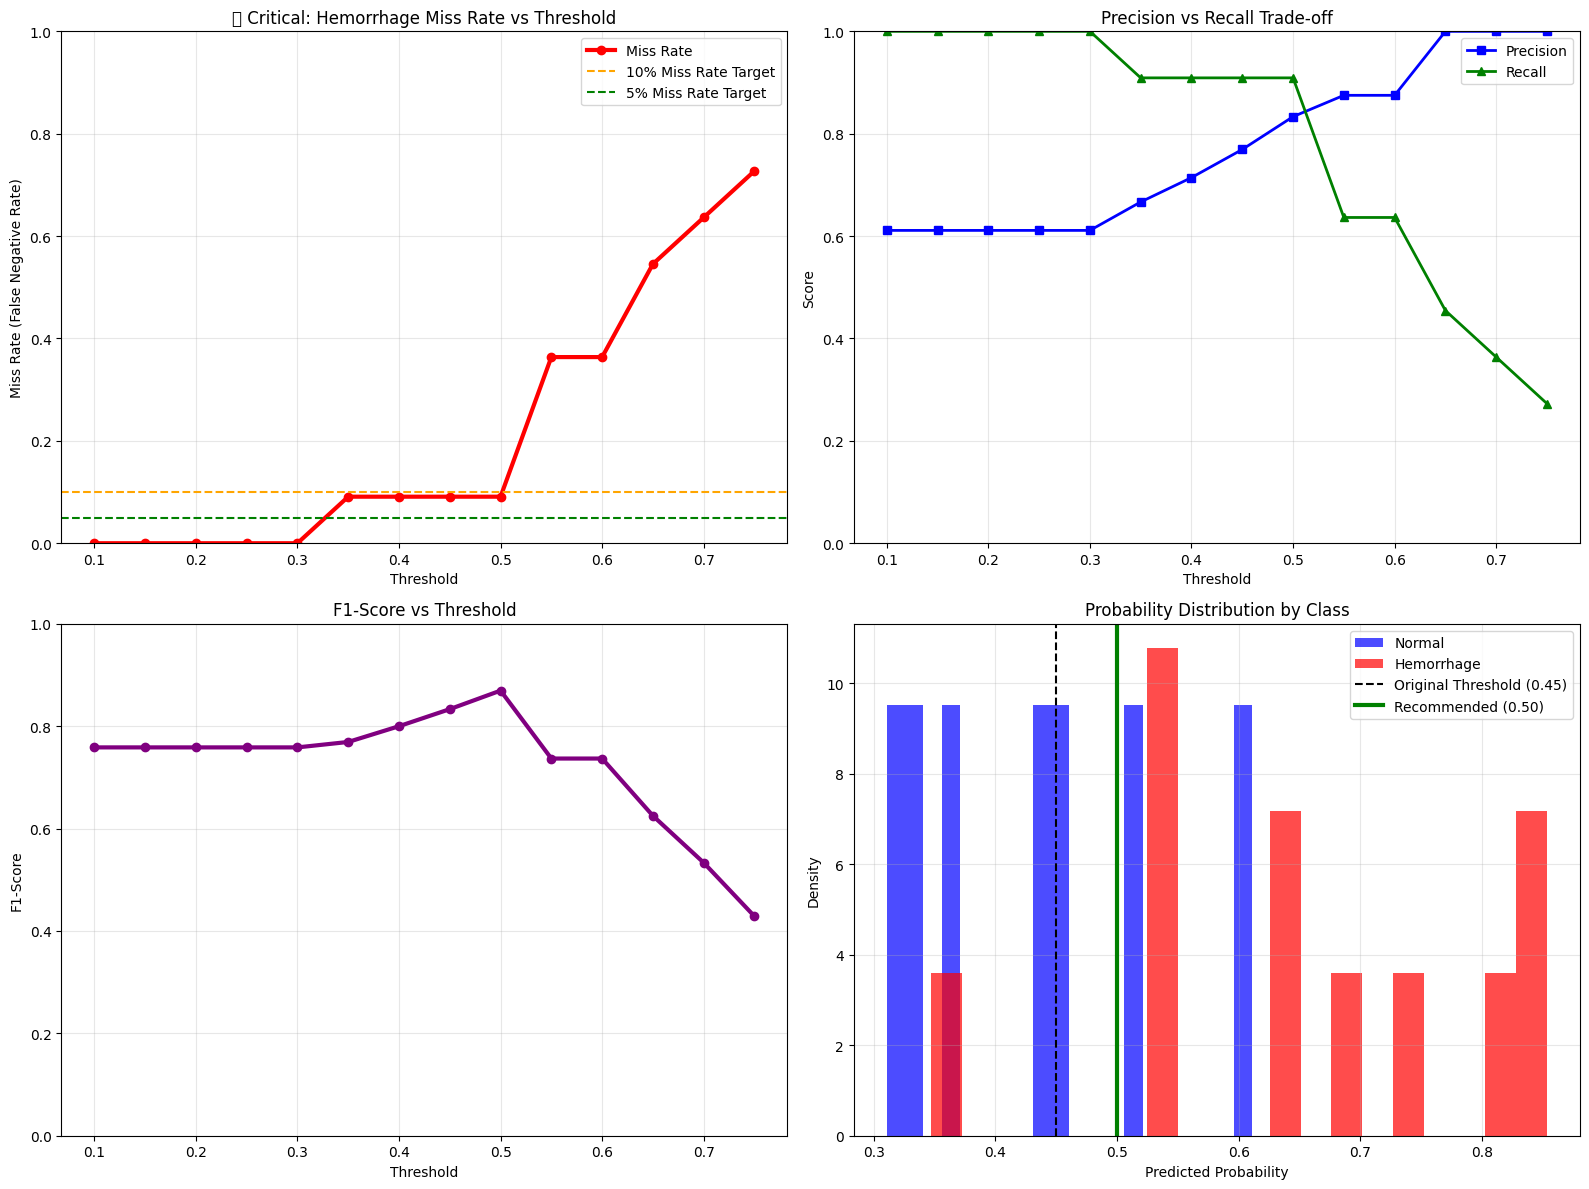


🎯 FINAL EVALUATION WITH RECOMMENDED THRESHOLD: 0.50

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.83      0.71      0.77         7
  Hemorrhage       0.83      0.91      0.87        11

    accuracy                           0.83        18
   macro avg       0.83      0.81      0.82        18
weighted avg       0.83      0.83      0.83        18



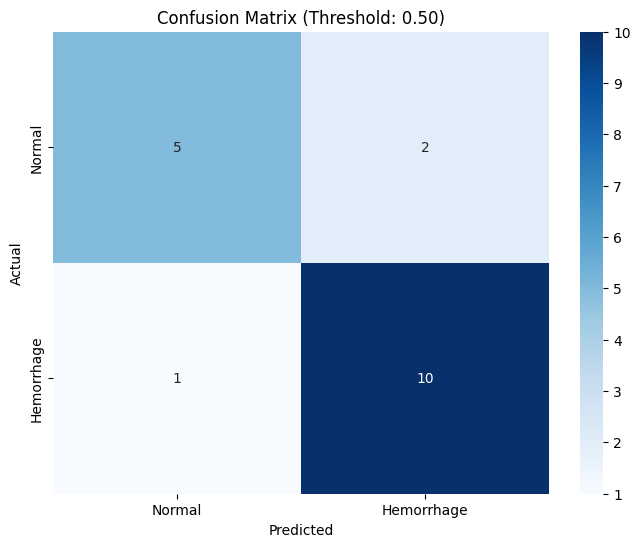


🎯 CRITICAL METRICS SUMMARY:
   Missed Hemorrhages: 1 out of 11 (9.1%)
   False Alarms: 2 out of 7 (28.6%)
   Recommended Threshold: 0.50
   ✅ CLINICAL STATUS: Acceptable miss rate

🎯 FINAL RECOMMENDATION:
   USE THRESHOLD: 0.500
   Save this value for your production model!
💾 Results saved:
   - recommended_threshold.txt
   - threshold_optimization_results.json


In [4]:
# -*- coding: utf-8 -*-
"""
Optimized Hemorrhage Detection Model
Focus: Reducing False Negatives (Missed Hemorrhages)
"""

import os
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================
# 1. MODEL ARCHITECTURE (Your Working Model)
# =====================================================

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class ResUNetEncoder(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        for feature in features:
            self.encoder_blocks.append(ConvBlock(in_channels, feature))
            in_channels = feature

    def forward(self, x):
        for encoder in self.encoder_blocks:
            x = encoder(x)
            x = self.pool(x)
        return x

class ImprovedResUNetClassifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, features=[64, 128, 256, 512], dropout=0.3):
        super().__init__()
        self.encoder = ResUNetEncoder(in_channels, features)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(features[-1], 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# =====================================================
# 2. DATASET CLASS (Your Working Dataset)
# =====================================================

class RetinalHemorrhageDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, file_names, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.file_names = file_names
        self.transform = transform

    def check_hemorrhages_in_xml(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            for marking in root.findall('.//marking'):
                marking_type = marking.find('markingtype').text.strip()
                if 'Haemorrhages' in marking_type:
                    return 1
            return 0
        except Exception as e:
            print(f"Error parsing XML: {annotation_path}, {e}")
            return 0

    def parse_annotations(self, image_name):
        base_name = image_name.replace('.png', '')
        xml_files = [f for f in os.listdir(self.annotation_dir) if f.startswith(base_name) and f.endswith('.xml')]
        for xml_file in xml_files:
            if not xml_file.endswith('_plain.xml'):
                label = self.check_hemorrhages_in_xml(os.path.join(self.annotation_dir, xml_file))
                if label == 1:
                    return 1
        return 0

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = self.file_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = np.array(Image.open(img_path).convert("RGB"))
        label = self.parse_annotations(img_name)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            image = ToTensorV2()(image=image)['image']

        return image, torch.tensor(label, dtype=torch.float32)

# =====================================================
# 3. ENHANCED THRESHOLD OPTIMIZATION FUNCTION
# =====================================================

def comprehensive_threshold_analysis(model, val_loader, device, thresholds=None):
    """
    Comprehensive threshold analysis focusing on reducing false negatives
    """
    if thresholds is None:
        # Focus on lower thresholds to catch more hemorrhages
        thresholds = np.arange(0.1, 0.8, 0.05)

    model.eval()

    # Get all predictions first
    all_probs = []
    all_labels = []

    print("🔍 Collecting model predictions...")
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images)
            probs = torch.sigmoid(outputs)

            all_probs.extend(probs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    print(f"📊 Total samples: {len(all_labels)}")
    print(f"   Hemorrhages: {int(np.sum(all_labels))} ({np.sum(all_labels)/len(all_labels)*100:.1f}%)")
    print(f"   Normal: {int(len(all_labels) - np.sum(all_labels))} ({(len(all_labels) - np.sum(all_labels))/len(all_labels)*100:.1f}%)")

    # Analyze each threshold
    results = []
    print("\n" + "="*80)
    print("🎯 THRESHOLD OPTIMIZATION - FOCUS: Reduce Missed Hemorrhages")
    print("="*80)
    print("Thresh | Accuracy | Precision | Recall | F1-Score | Miss Rate | False Alarms")
    print("-"*80)

    for thresh in thresholds:
        preds = (all_probs > thresh).astype(int)

        # Calculate metrics
        tp = np.sum((preds == 1) & (all_labels == 1))
        fp = np.sum((preds == 1) & (all_labels == 0))
        fn = np.sum((preds == 0) & (all_labels == 1))
        tn = np.sum((preds == 0) & (all_labels == 0))

        accuracy = (tp + tn) / len(all_labels) if len(all_labels) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Critical metrics for medical application
        miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0  # False Negative Rate
        false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

        results.append({
            'threshold': thresh,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'miss_rate': miss_rate,
            'false_alarm_rate': false_alarm_rate,
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
        })

        # Color coding for critical miss rates
        if miss_rate <= 0.1:
            status = "🟢"  # Excellent
        elif miss_rate <= 0.2:
            status = "🟡"  # Acceptable
        else:
            status = "🔴"  # Dangerous

        print(f"{thresh:.2f}   |   {accuracy:.3f}  |   {precision:.3f}   |  {recall:.3f}  |  {f1:.3f}   |   {miss_rate:.3f}   |     {false_alarm_rate:.3f}    {status}")

    return results, all_probs, all_labels

# =====================================================
# 4. CLINICAL THRESHOLD RECOMMENDATION
# =====================================================

def recommend_clinical_threshold(results):
    """
    Recommend threshold based on clinical priorities
    """
    print("\n" + "="*80)
    print("🏥 CLINICAL THRESHOLD RECOMMENDATIONS")
    print("="*80)

    # Find thresholds with different miss rate targets
    targets = [0.05, 0.10, 0.15, 0.20]  # 5%, 10%, 15%, 20% miss rates

    for target_miss_rate in targets:
        suitable_thresholds = [r for r in results if r['miss_rate'] <= target_miss_rate]

        if suitable_thresholds:
            # Among suitable thresholds, pick the one with best F1 score
            best = max(suitable_thresholds, key=lambda x: x['f1'])

            print(f"\n📋 For ≤{target_miss_rate*100:.0f}% Miss Rate:")
            print(f"   Recommended Threshold: {best['threshold']:.2f}")
            print(f"   Miss Rate: {best['miss_rate']*100:.1f}% ({int(best['fn'])} missed hemorrhages)")
            print(f"   False Alarms: {best['false_alarm_rate']*100:.1f}% ({int(best['fp'])} false positives)")
            print(f"   F1-Score: {best['f1']:.3f}")
            print(f"   Accuracy: {best['accuracy']:.3f}")
        else:
            print(f"\n❌ No threshold achieves ≤{target_miss_rate*100:.0f}% miss rate")

    # Overall recommendation
    print(f"\n💡 CLINICAL RECOMMENDATION:")

    # Find threshold with miss rate ≤ 10% and best F1
    clinical_candidates = [r for r in results if r['miss_rate'] <= 0.15]  # 15% max miss rate

    if clinical_candidates:
        recommended = max(clinical_candidates, key=lambda x: x['f1'])
        print(f"   🎯 USE THRESHOLD: {recommended['threshold']:.2f}")
        print(f"   📊 Performance:")
        print(f"      • Will miss {recommended['miss_rate']*100:.1f}% of hemorrhages ({int(recommended['fn'])} cases)")
        print(f"      • Will have {recommended['false_alarm_rate']*100:.1f}% false alarms ({int(recommended['fp'])} cases)")
        print(f"      • Overall accuracy: {recommended['accuracy']*100:.1f}%")
        print(f"      • F1-Score: {recommended['f1']:.3f}")

        if recommended['miss_rate'] <= 0.1:
            print(f"   ✅ CLINICAL STATUS: Acceptable for medical use")
        elif recommended['miss_rate'] <= 0.2:
            print(f"   ⚠️  CLINICAL STATUS: Use with caution - requires human oversight")
        else:
            print(f"   🚨 CLINICAL STATUS: NOT SAFE for clinical use")

        return recommended['threshold']
    else:
        print(f"   🚨 CRITICAL: Model cannot achieve safe miss rate")
        print(f"   🔧 ACTIONS NEEDED:")
        print(f"      • Retrain with more hemorrhage data")
        print(f"      • Use ensemble methods")
        print(f"      • Consider transfer learning")
        return 0.3  # Conservative fallback

# =====================================================
# 5. VISUALIZATION FUNCTIONS
# =====================================================

def plot_threshold_analysis(results, all_probs, all_labels):
    """
    Create comprehensive visualizations
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Extract metrics
    thresholds = [r['threshold'] for r in results]
    miss_rates = [r['miss_rate'] for r in results]
    f1_scores = [r['f1'] for r in results]
    recalls = [r['recall'] for r in results]
    precisions = [r['precision'] for r in results]

    # 1. Miss Rate vs Threshold (Most Important)
    ax1.plot(thresholds, miss_rates, 'r-', linewidth=3, label='Miss Rate', marker='o')
    ax1.axhline(y=0.1, color='orange', linestyle='--', label='10% Miss Rate Target')
    ax1.axhline(y=0.05, color='green', linestyle='--', label='5% Miss Rate Target')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Miss Rate (False Negative Rate)')
    ax1.set_title('🚨 Critical: Hemorrhage Miss Rate vs Threshold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    # 2. Precision-Recall Trade-off
    ax2.plot(thresholds, precisions, 'b-', linewidth=2, label='Precision', marker='s')
    ax2.plot(thresholds, recalls, 'g-', linewidth=2, label='Recall', marker='^')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Score')
    ax2.set_title('Precision vs Recall Trade-off')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)

    # 3. F1-Score
    ax3.plot(thresholds, f1_scores, 'purple', linewidth=3, marker='o')
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel('F1-Score')
    ax3.set_title('F1-Score vs Threshold')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)

    # 4. Probability Distribution
    hemorrhage_probs = all_probs[all_labels == 1]
    normal_probs = all_probs[all_labels == 0]

    ax4.hist(normal_probs, bins=20, alpha=0.7, label='Normal', color='blue', density=True)
    ax4.hist(hemorrhage_probs, bins=20, alpha=0.7, label='Hemorrhage', color='red', density=True)
    ax4.axvline(x=0.45, color='black', linestyle='--', label='Original Threshold (0.45)')

    # Show recommended threshold
    clinical_candidates = [r for r in results if r['miss_rate'] <= 0.15]
    if clinical_candidates:
        recommended = max(clinical_candidates, key=lambda x: x['f1'])
        ax4.axvline(x=recommended['threshold'], color='green', linestyle='-', linewidth=3,
                   label=f'Recommended ({recommended["threshold"]:.2f})')

    ax4.set_xlabel('Predicted Probability')
    ax4.set_ylabel('Density')
    ax4.set_title('Probability Distribution by Class')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# =====================================================
# 6. MAIN EXECUTION FUNCTION
# =====================================================

def optimize_hemorrhage_detection_threshold(model_path, image_dir, annotation_dir, test_files):
    """
    Complete threshold optimization pipeline
    """
    print("🚀 STARTING HEMORRHAGE DETECTION THRESHOLD OPTIMIZATION")
    print("="*80)

    # Setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"📱 Using device: {device}")

    # Load model
    model = ImprovedResUNetClassifier(dropout=0.3)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    print(f"✅ Model loaded from: {model_path}")

    # Setup data
    val_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    test_dataset = RetinalHemorrhageDataset(image_dir, annotation_dir, test_files, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
    print(f"📊 Test dataset: {len(test_files)} images")

    # Run threshold analysis
    results, all_probs, all_labels = comprehensive_threshold_analysis(model, test_loader, device)

    # Get clinical recommendation
    recommended_threshold = recommend_clinical_threshold(results)

    # Create visualizations
    plot_threshold_analysis(results, all_probs, all_labels)

    # Final evaluation with recommended threshold
    print(f"\n" + "="*80)
    print(f"🎯 FINAL EVALUATION WITH RECOMMENDED THRESHOLD: {recommended_threshold:.2f}")
    print("="*80)

    # Evaluate with recommended threshold
    model.eval()
    final_preds = []
    final_labels = []
    final_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > recommended_threshold).float()

            final_preds.extend(preds.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())
            final_probs.extend(probs.cpu().numpy())

    final_preds = np.array(final_preds).flatten()
    final_labels = np.array(final_labels).flatten()
    final_probs = np.array(final_probs).flatten()

    # Classification report
    print("\n📋 CLASSIFICATION REPORT:")
    print(classification_report(final_labels, final_preds, target_names=['Normal', 'Hemorrhage']))

    # Confusion matrix
    cm = confusion_matrix(final_labels, final_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Hemorrhage'],
                yticklabels=['Normal', 'Hemorrhage'])
    plt.title(f'Confusion Matrix (Threshold: {recommended_threshold:.2f})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Critical metrics summary
    tn, fp, fn, tp = cm.ravel()
    miss_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

    print(f"\n🎯 CRITICAL METRICS SUMMARY:")
    print(f"   Missed Hemorrhages: {fn} out of {fn + tp} ({miss_rate*100:.1f}%)")
    print(f"   False Alarms: {fp} out of {fp + tn} ({false_alarm_rate*100:.1f}%)")
    print(f"   Recommended Threshold: {recommended_threshold:.2f}")

    if miss_rate <= 0.1:
        print(f"   ✅ CLINICAL STATUS: Acceptable miss rate")
    elif miss_rate <= 0.2:
        print(f"   ⚠️  CLINICAL STATUS: Use with caution")
    else:
        print(f"   🚨 CLINICAL STATUS: Requires model improvement")

    return recommended_threshold, results

# =====================================================
# 7. USAGE EXAMPLE
# =====================================================

"""
USAGE EXAMPLE: Hemorrhage Detection Threshold Optimization
Complete implementation example
"""

import os
import glob
from pathlib import Path

# =====================================================
# STEP 1: PREPARE YOUR DATA PATHS AND FILES
# =====================================================

# Set your data paths
image_dir = '/content/DIARETDB1_DATA/DIARETDB1/images'
annotation_dir = '/content/DIARETDB1_DATA/DIARETDB1/groundtruth'
model_path = "best_resunet_classifier.pth"

# Function to get all image files and create train/test split
def prepare_dataset_files(image_dir, test_size=0.2, random_state=42):
    """
    Prepare train/test split from image directory
    """
    # Get all image files
    all_files = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        all_files.extend(glob.glob(os.path.join(image_dir, ext)))

    # Extract just filenames
    file_names = [os.path.basename(f) for f in all_files]

    print(f"📁 Found {len(file_names)} images in {image_dir}")

    # Create train/test split
    from sklearn.model_selection import train_test_split
    train_files, test_files = train_test_split(
        file_names,
        test_size=test_size,
        random_state=random_state,
        shuffle=True
    )

    print(f"📊 Train files: {len(train_files)}")
    print(f"📊 Test files: {len(test_files)}")

    return train_files, test_files

# =====================================================
# STEP 2: RUN THE COMPLETE OPTIMIZATION
# =====================================================

def main():
    """
    Main function to run threshold optimization
    """
    print("🚀 HEMORRHAGE DETECTION THRESHOLD OPTIMIZATION")
    print("=" * 60)

    # Check if paths exist
    if not os.path.exists(image_dir):
        print(f"❌ Image directory not found: {image_dir}")
        print("Please update the image_dir path to your actual data location")
        return

    if not os.path.exists(annotation_dir):
        print(f"❌ Annotation directory not found: {annotation_dir}")
        print("Please update the annotation_dir path to your actual data location")
        return

    if not os.path.exists(model_path):
        print(f"❌ Model file not found: {model_path}")
        print("Please ensure your trained model is saved at this location")
        return

    # Prepare dataset files
    train_files, test_files = prepare_dataset_files(image_dir)

    # Run threshold optimization
    try:
        recommended_threshold, analysis_results = optimize_hemorrhage_detection_threshold(
            model_path=model_path,
            image_dir=image_dir,
            annotation_dir=annotation_dir,
            test_files=test_files
        )

        print(f"\n🎯 FINAL RECOMMENDATION:")
        print(f"   USE THRESHOLD: {recommended_threshold:.3f}")
        print(f"   Save this value for your production model!")

        # Save results
        save_optimization_results(recommended_threshold, analysis_results)

    except Exception as e:
        print(f"❌ Error during optimization: {str(e)}")
        print("Please check your model file and data paths")

# =====================================================
# STEP 3: ALTERNATIVE - LOAD EXISTING TEST FILES
# =====================================================

def run_with_existing_split():
    """
    If you already have train/test split files
    """
    # Load existing test files (replace with your actual file loading)
    test_files = [
        "image_001.png", "image_002.png", "image_003.png",  # Example files
        # Add your actual test file names here
    ]

    # Or load from a saved file
    # test_files = np.load('test_files.npy').tolist()  # If saved as numpy
    # Or from text file:
    # with open('test_files.txt', 'r') as f:
    #     test_files = [line.strip() for line in f.readlines()]

    print(f"📊 Using {len(test_files)} test files")

    # Run optimization
    recommended_threshold, analysis_results = optimize_hemorrhage_detection_threshold(
        model_path=model_path,
        image_dir=image_dir,
        annotation_dir=annotation_dir,
        test_files=test_files
    )

    return recommended_threshold

# =====================================================
# STEP 4: SAVE RESULTS FOR FUTURE USE
# =====================================================

def save_optimization_results(threshold, results):
    """
    Save optimization results for future reference
    """
    # Save recommended threshold
    with open('recommended_threshold.txt', 'w') as f:
        f.write(f"RECOMMENDED_THRESHOLD={threshold:.3f}\n")
        f.write(f"# Use this threshold for hemorrhage detection\n")
        f.write(f"# Generated by threshold optimization\n")

    # Save detailed results
    import json
    results_summary = {
        'recommended_threshold': float(threshold),
        'optimization_results': [
            {
                'threshold': float(r['threshold']),
                'accuracy': float(r['accuracy']),
                'precision': float(r['precision']),
                'recall': float(r['recall']),
                'f1': float(r['f1']),
                'miss_rate': float(r['miss_rate']),
                'false_alarm_rate': float(r['false_alarm_rate'])
            }
            for r in results
        ]
    }

    with open('threshold_optimization_results.json', 'w') as f:
        json.dump(results_summary, f, indent=2)

    print(f"💾 Results saved:")
    print(f"   - recommended_threshold.txt")
    print(f"   - threshold_optimization_results.json")

# =====================================================
# STEP 5: LOAD SAVED THRESHOLD FOR PRODUCTION
# =====================================================

def load_recommended_threshold():
    """
    Load the recommended threshold for use in production
    """
    try:
        with open('recommended_threshold.txt', 'r') as f:
            line = f.readline().strip()
            threshold = float(line.split('=')[1])
        print(f"✅ Loaded recommended threshold: {threshold:.3f}")
        return threshold
    except:
        print("❌ Could not load recommended threshold, using default 0.5")
        return 0.5

# =====================================================
# STEP 6: PRODUCTION INFERENCE EXAMPLE
# =====================================================

def predict_with_optimized_threshold(model, image, device, threshold=None):
    """
    Use the model with optimized threshold for prediction
    """
    if threshold is None:
        threshold = load_recommended_threshold()

    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        prob = torch.sigmoid(output)
        prediction = (prob > threshold).float()

    return prediction.cpu().numpy(), prob.cpu().numpy()

# =====================================================
# COMPLETE EXAMPLE EXECUTION
# =====================================================

if __name__ == "__main__":
    print("📋 HEMORRHAGE DETECTION THRESHOLD OPTIMIZATION")
    print("Choose your execution method:\n")

    print("Option 1: Auto-split dataset and optimize")
    print("Option 2: Use existing test files")
    print("Option 3: Load saved threshold only")

    choice = input("\nEnter choice (1/2/3): ").strip()

    if choice == "1":
        # Method 1: Auto-split and optimize
        main()

    elif choice == "2":
        # Method 2: Use existing split
        try:
            threshold = run_with_existing_split()
            print(f"🎯 Recommended threshold: {threshold:.3f}")
        except Exception as e:
            print(f"❌ Error: {e}")

    elif choice == "3":
        # Method 3: Just load existing threshold
        threshold = load_recommended_threshold()
        print(f"📊 Current recommended threshold: {threshold:.3f}")

    else:
        print("❌ Invalid choice")


In [11]:
def visualize_hemorrhage_predictions(model, test_loader, device, save_dir=None,
                                     class_names=["Normal", "Hemorrhage"],
                                     threshold=0.20, show_confidence=True):
    import matplotlib.pyplot as plt
    import os
    import torch
    import torchvision.transforms as T

    model.eval()
    if save_dir:
        for folder in ["correct", "incorrect", "critical_misses", "false_alarms"]:
            os.makedirs(os.path.join(save_dir, folder), exist_ok=True)

    to_pil = T.ToPILImage()

    correct_predictions = 0
    total_predictions = 0
    false_negatives = []
    false_positives = []
    high_confidence_errors = []
    uncertain_predictions = []

    print("🔍 VISUALIZATION STARTED")
    print(f"🧪 Threshold: {threshold:.3f} | Showing confidence: {show_confidence}")
    print("="*60)

    def get_prediction_stats(label, pred, confidence):
        is_correct = (label == pred)
        high_conf = confidence > 0.7 or confidence < 0.3
        uncertain = 0.3 <= confidence <= 0.7
        critical_miss = (label == 1 and pred == 0)
        false_alarm = (label == 0 and pred == 1)
        return is_correct, critical_miss, false_alarm, high_conf, uncertain

    def format_title(is_correct, critical_miss, false_alarm, prediction_class, actual_class, confidence):
        if critical_miss:
            return "🚨 CRITICAL MISS", "red", "HIGH PRIORITY"
        elif false_alarm:
            return "⚠️ FALSE ALARM", "orange", "REVIEW NEEDED"
        else:
            return "✅ CORRECT", "green", "CONFIRMED"

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > threshold).astype(int)

            for j in range(images.size(0)):
                total_predictions += 1
                image_tensor = images[j].cpu()
                label = int(labels[j].item())
                prob = probs[j][0]
                pred = preds[j][0]

                # Denormalize (ImageNet)
                mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
                std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
                image_tensor = image_tensor * std + mean
                image_tensor = torch.clamp(image_tensor, 0, 1)
                img = to_pil(image_tensor)

                is_correct, critical_miss, false_alarm, high_conf, uncertain = get_prediction_stats(label, pred, prob)

                if is_correct:
                    correct_predictions += 1
                else:
                    if critical_miss:
                        false_negatives.append({'batch_idx': batch_idx, 'sample_idx': j, 'confidence': prob, 'image': img})
                    if false_alarm:
                        false_positives.append({'batch_idx': batch_idx, 'sample_idx': j, 'confidence': prob, 'image': img})
                    if high_conf:
                        high_confidence_errors.append({'batch_idx': batch_idx, 'sample_idx': j, 'confidence': prob, 'type': 'fn' if critical_miss else 'fp'})

                if uncertain:
                    uncertain_predictions.append({'batch_idx': batch_idx, 'sample_idx': j, 'confidence': prob, 'correct': is_correct})

                pred_class = class_names[pred]
                actual_class = class_names[label]
                status, title_color, priority = format_title(is_correct, critical_miss, false_alarm, pred_class, actual_class, prob)

                # Plot
                fig, ax = plt.subplots(figsize=(6, 6))
                ax.imshow(img)
                ax.axis("off")
                if show_confidence:
                    title = f"{status} - {priority}\nPredicted: {pred_class} (conf: {prob:.3f}) | Actual: {actual_class}"
                else:
                    title = f"{status} | Predicted: {pred_class} | Actual: {actual_class}"
                ax.set_title(title, color=title_color, fontsize=11)

                # Confidence annotation
                if show_confidence:
                    conf_color = 'red' if prob < threshold else 'blue'
                    ax.text(0.02, 0.98, f'Confidence: {prob:.3f}',
                            transform=ax.transAxes, fontsize=10, weight='bold',
                            verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor=conf_color, alpha=0.7))

                # Save image
                if save_dir:
                    if critical_miss:
                        subfolder = "critical_misses"
                        prefix = "CRITICAL"
                    elif false_alarm:
                        subfolder = "false_alarms"
                        prefix = "FALSE_ALARM"
                    else:
                        subfolder = "correct"
                        prefix = "CORRECT"

                    filename = f"{prefix}_b{batch_idx:02d}_s{j:02d}_conf{prob:.3f}.png"
                    filepath = os.path.join(save_dir, subfolder, filename)
                    plt.savefig(filepath, bbox_inches='tight', dpi=150, facecolor='white')
                    plt.close()
                else:
                    plt.tight_layout()
                    plt.show()

                # Console summary
                symbol = "🚨" if critical_miss else "⚠️" if false_alarm else "✅"
                print(f"{symbol} Sample {total_predictions:3d}: Pred={pred_class:12s} (conf: {prob:.3f}) | Actual={actual_class:12s} | {'MISS' if not is_correct else 'OK'}")

    # Summary
    print("\n" + "="*70)
    print("🏥 HEMORRHAGE DETECTION SUMMARY")
    print("="*70)
    accuracy = correct_predictions / total_predictions
    print(f"Total samples: {total_predictions}")
    print(f"Correct: {correct_predictions} ({accuracy*100:.1f}%)")
    print(f"Incorrect: {total_predictions - correct_predictions}")

    if false_negatives:
        print(f"\n🚨 Missed hemorrhages: {len(false_negatives)}")
        print(f"Miss rate: {len(false_negatives) / total_predictions * 100:.1f}%")
        missed_confidences = [f"{fn['confidence']:.3f}" for fn in false_negatives[:5]]
        print(f"First few missed cases (confidence): {missed_confidences}")
    else:
        print("\n✅ No missed hemorrhages!")

    if false_positives:
        print(f"\n⚠️ False alarms: {len(false_positives)} ({len(false_positives) / total_predictions * 100:.1f}%)")
        high_fp = [fp for fp in false_positives if fp['confidence'] > 0.7]
        print(f"🔴 High-confidence false alarms: {len(high_fp)}")

    if uncertain_predictions:
        print(f"\n🤔 Uncertain cases: {len(uncertain_predictions)}")
        correct_uncertain = sum(1 for x in uncertain_predictions if x['correct'])
        print(f"Correct among uncertain: {correct_uncertain}/{len(uncertain_predictions)}")

    # Final recommendation
    print("\n💡 RECOMMENDATION:")
    if len(false_negatives) > total_predictions * 0.1:
        print(f"🚨 High miss rate. Consider lowering threshold or retraining model.")
    else:
        print("✅ Miss rate acceptable.")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your model if needed
model.load_state_dict(torch.load("/content/best_resunet_classifier.pth"))
model.to(device)

# Run visualization
visualize_hemorrhage_predictions(
    model=model,
    test_loader=test_loader,
    device=device,
    save_dir="visualization_results",  # Save to this folder
    class_names=["Normal", "Hemorrhage"],
    threshold=0.45,
    show_confidence=True
)


🔍 VISUALIZATION STARTED
🧪 Threshold: 0.450 | Showing confidence: True


<ipython-input-11-ea0fa0585191>:116: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(filepath, bbox_inches='tight', dpi=150, facecolor='white')


✅ Sample   1: Pred=Hemorrhage   (conf: 0.660) | Actual=Hemorrhage   | OK
✅ Sample   2: Pred=Normal       (conf: 0.289) | Actual=Normal       | OK
⚠️ Sample   3: Pred=Hemorrhage   (conf: 0.563) | Actual=Normal       | MISS
✅ Sample   4: Pred=Normal       (conf: 0.224) | Actual=Normal       | OK


<ipython-input-11-ea0fa0585191>:116: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.savefig(filepath, bbox_inches='tight', dpi=150, facecolor='white')


🚨 Sample   5: Pred=Normal       (conf: 0.243) | Actual=Hemorrhage   | MISS
🚨 Sample   6: Pred=Normal       (conf: 0.349) | Actual=Hemorrhage   | MISS
✅ Sample   7: Pred=Normal       (conf: 0.370) | Actual=Normal       | OK
✅ Sample   8: Pred=Hemorrhage   (conf: 0.581) | Actual=Hemorrhage   | OK
✅ Sample   9: Pred=Hemorrhage   (conf: 0.547) | Actual=Hemorrhage   | OK
⚠️ Sample  10: Pred=Hemorrhage   (conf: 0.532) | Actual=Normal       | MISS
✅ Sample  11: Pred=Hemorrhage   (conf: 0.455) | Actual=Hemorrhage   | OK
✅ Sample  12: Pred=Hemorrhage   (conf: 0.696) | Actual=Hemorrhage   | OK
✅ Sample  13: Pred=Normal       (conf: 0.332) | Actual=Normal       | OK
🚨 Sample  14: Pred=Normal       (conf: 0.386) | Actual=Hemorrhage   | MISS

🏥 HEMORRHAGE DETECTION SUMMARY
Total samples: 14
Correct: 9 (64.3%)
Incorrect: 5

🚨 Missed hemorrhages: 3
Miss rate: 21.4%
First few missed cases (confidence): ['0.243', '0.349', '0.386']

⚠️ False alarms: 2 (14.3%)
🔴 High-confidence false alarms: 0

🤔 Uncerta

In [17]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your ImprovedResUNetClassifier model architecture (simplified example)
class ImprovedResUNetClassifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, features=[64, 128, 256, 512], dropout=0.3):
        super().__init__()
        # You should define your encoder architecture here exactly as in training code
        # Here I'm assuming `ResUNetEncoder` is already defined somewhere
        self.encoder = ResUNetEncoder(in_channels, features)  # Make sure you import or define ResUNetEncoder
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(features[-1], 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model = ImprovedResUNetClassifier(dropout=0.3)
# Load the saved weights
checkpoint = torch.load("/content/best_resunet_classifier.pth", map_location=device)
model.load_state_dict(checkpoint)

model = model.to(device)
model.eval()

# Define transforms consistent with training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = ["Normal", "Hemorrhage"]
threshold = 0.25

def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > threshold else 0
        predicted_class = class_names[pred]

    print(f"\n🖼️ Image: {image_path}")
    print(f"🔍 Prediction: {predicted_class} (Confidence: {prob:.3f})")
    return predicted_class, prob

if __name__ == "__main__":
    test_image_path = "/content/DIARETDB1_DATA/DIARETDB1/images/diaretdb1_image048.png"
    predict_image(test_image_path)



🖼️ Image: /content/DIARETDB1_DATA/DIARETDB1/images/diaretdb1_image048.png
🔍 Prediction: Hemorrhage (Confidence: 0.348)


In [18]:
import os
import csv
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Define your model architecture here ===
# (Make sure you have ResUNetEncoder defined or imported)

class ImprovedResUNetClassifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, features=[64, 128, 256, 512], dropout=0.3):
        super().__init__()
        # Replace this with your actual ResUNetEncoder definition
        self.encoder = ResUNetEncoder(in_channels, features)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(features[-1], 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# === Instantiate and load model weights ===
model = ImprovedResUNetClassifier(dropout=0.3)
checkpoint = torch.load("/content/best_resunet_classifier.pth", map_location=device)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

# === Image transformations ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = ["Normal", "Hemorrhage"]
threshold = 0.25

# === Directory containing images ===
image_dir = "/content/DIARETDB1_DATA/DIARETDB1/images"

# === Output CSV path ===
csv_output_path = "/content/predictions.csv"

# === Function to predict a single image ===
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > threshold else 0
        predicted_class = class_names[pred]
    return predicted_class, prob

# === Run predictions on all images and save to CSV ===
def run_inference_and_save_csv():
    results = []
    for fname in os.listdir(image_dir):
        if fname.lower().endswith((".png", ".jpg", ".jpeg", ".tif")):
            img_path = os.path.join(image_dir, fname)
            pred_class, conf = predict_image(img_path)
            print(f"{fname} => {pred_class} (Confidence: {conf:.3f})")
            results.append([fname, pred_class, conf])

    # Save results to CSV
    with open(csv_output_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["image_name", "predicted_class", "confidence"])
        writer.writerows(results)
    print(f"\n✅ Predictions saved to {csv_output_path}")

if __name__ == "__main__":
    run_inference_and_save_csv()


diaretdb1_image031.png => Hemorrhage (Confidence: 0.448)
diaretdb1_image043.png => Hemorrhage (Confidence: 0.823)
diaretdb1_image057.png => Hemorrhage (Confidence: 0.516)
diaretdb1_image021.png => Hemorrhage (Confidence: 0.699)
diaretdb1_image079.png => Hemorrhage (Confidence: 0.427)
diaretdb1_image032.png => Normal (Confidence: 0.245)
diaretdb1_image060.png => Hemorrhage (Confidence: 0.412)
diaretdb1_image087.png => Hemorrhage (Confidence: 0.273)
diaretdb1_image064.png => Hemorrhage (Confidence: 0.611)
diaretdb1_image024.png => Hemorrhage (Confidence: 0.737)
diaretdb1_image036.png => Hemorrhage (Confidence: 0.638)
diaretdb1_image045.png => Normal (Confidence: 0.244)
diaretdb1_image088.png => Hemorrhage (Confidence: 0.309)
diaretdb1_image081.png => Normal (Confidence: 0.245)
diaretdb1_image048.png => Hemorrhage (Confidence: 0.348)
diaretdb1_image053.png => Hemorrhage (Confidence: 0.579)
diaretdb1_image073.png => Hemorrhage (Confidence: 0.453)
diaretdb1_image028.png => Hemorrhage (Confi

In [21]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

class HemorrhageLabelExtractor:
    def __init__(self, image_dir, annotation_dir):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir

    def parse_annotations(self, image_name):
        base_name = image_name.replace('.png', '')  # strip extension
        xml_files = [f for f in os.listdir(self.annotation_dir)
                     if f.startswith(base_name) and f.endswith('.xml')]

        for xml_file in xml_files:
            if not xml_file.endswith('_plain.xml'):  # skip _plain.xml files if needed
                path = os.path.join(self.annotation_dir, xml_file)
                if self.check_hemorrhages_in_xml(path) == 1:
                    return 1  # hemorrhage found
        return 0  # no hemorrhage found

    def check_hemorrhages_in_xml(self, xml_path):
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for marking in root.findall('.//marking'):
                markingtype_elem = marking.find('markingtype')
                if markingtype_elem is not None:
                    marking_type = markingtype_elem.text.strip()
                    if 'Haemorrhages' in marking_type:
                        return 1
            return 0
        except Exception as e:
            print(f"Error parsing {xml_path}: {e}")
            return 0

def generate_labels_csv(image_dir, annotation_dir, output_csv):
    extractor = HemorrhageLabelExtractor(image_dir, annotation_dir)
    data = []

    for image_file in os.listdir(image_dir):
        if not image_file.lower().endswith('.png'):
            continue
        label = extractor.parse_annotations(image_file)
        data.append({'image': image_file, 'label': label})

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved labels CSV to: {output_csv}")

# Usage example:
image_dir = '/content/DIARETDB1_DATA/DIARETDB1/images'
annotation_dir = '/content/DIARETDB1_DATA/DIARETDB1/groundtruth'
output_csv = '/content/DIARETDB1_DATA/DIARETDB1/labels.csv'

generate_labels_csv(image_dir, annotation_dir, output_csv)


✅ Saved labels CSV to: /content/DIARETDB1_DATA/DIARETDB1/labels.csv


In [25]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import xml.etree.ElementTree as ET
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import your model class and instantiate the model here
#from improved_resunet_classifier import ImprovedResUNetClassifier  # adjust as needed
model = ImprovedResUNetClassifier()
model.load_state_dict(torch.load("best_resunet_classifier.pth", map_location=device))
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

threshold = 0.25  # threshold for deciding positive class

def get_xml_label(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for child in root.iter('object'):
        name_tag = child.find('name')
        if name_tag is not None and 'hemorrhage' in name_tag.text.lower():
            return 1
    return 0

def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > threshold else 0
    return pred, prob

# Paths - update to your dataset paths
image_dir = "/content/DIARETDB1_DATA/DIARETDB1/images"
xml_dir = "/content/DIARETDB1_DATA/DIARETDB1/groundtruth"

# Get all images basenames without extension
image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
image_basenames = [os.path.splitext(f)[0] for f in image_files]

results = []

for base_name in sorted(image_basenames):
    # Find all XML files that start with the image base name
    related_xmls = [f for f in os.listdir(xml_dir) if f.startswith(base_name) and f.endswith(".xml")]

    if not related_xmls:
        print(f"No XML files found for {base_name}, skipping.")
        continue

    # Check all related XML files for hemorrhage
    xml_labels = []
    for xml_file in related_xmls:
        xml_path = os.path.join(xml_dir, xml_file)
        label = get_xml_label(xml_path)
        xml_labels.append(label)

    # If any XML file indicates hemorrhage, label = 1 else 0
    xml_label = 1 if any(xml_labels) else 0

    image_path = os.path.join(image_dir, base_name + ".png")
    if not os.path.exists(image_path):
        print(f"Image not found for {base_name}, skipping.")
        continue

    model_pred, confidence = predict_image(image_path)

    results.append({
        "image_name": base_name,
        "xml_label": xml_label,
        "model_prediction": model_pred,
        "confidence": confidence
    })

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv("comparison_results.csv", index=False)

print("Comparison complete! Results saved to comparison_results.csv")


Comparison complete! Results saved to comparison_results.csv
